# **nintendo**

# **ЗАДАНИЕ 5. ПОСТРОЕНИЕ ТРЕНД-СЕЗОННЫХ МОДЕЛЕЙ (МОДЕЛИРОВАНИЕ СЕЗОННЫХ КОЛЕБАНИЙ(здесь рассматривается классическое))**
Постройте тренд-сезонную модель, описывающую ряд данных по ценам на материал 2. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import linregress
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot
import scipy.stats
import seaborn as sns
from scipy.stats import t as student
from pandas import Grouper
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/наборы данных')

In [ ]:
data=read_csv('nintendo.csv')

In [ ]:
data.head(2)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.25,30.95,30.25,30.90,105408,USD
1,2010-01-05,31.15,32.50,31.05,31.47,210553,USD


__________________________________________

# **ДАТАСЕТ**

In [ ]:
df=data[['Date','Close']]

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df = df.drop(df.index[[300,550,551,800]])

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df=df.set_index('Date')

In [ ]:
series=df.squeeze() # переводим DataFrame в Series для дальнейшей работы
series.head(5)

Date
2018-01-02    45.90
2018-01-03    46.94
2018-01-04    48.53
2018-01-05    47.43
2018-01-08    47.56
Name: Close, dtype: float64

In [ ]:
series=series.resample('M').mean()

In [ ]:
df = series.reset_index()

In [ ]:
df = df.set_index('Date')

In [ ]:
df.shape

(48, 1)

_________________________________________

_____________________________________

# ***между линий фактическое значение за 4 месяца на 2022 год***

In [ ]:
df_2022=data[['Date','Close']]

In [ ]:
df_2022 = df_2022[-74:]

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df_2022['Date'] = pd.to_datetime(df_2022['Date'])

In [ ]:
df_2022.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [ ]:
df_2022=df_2022.set_index('Date')

In [ ]:
series_2022=df_2022.squeeze() # переводим DataFrame в Series для дальнейшей работы
series_2022.head(5)

Date
2022-01-03    58.52
2022-01-04    58.29
2022-01-05    56.94
2022-01-06    57.50
2022-01-07    58.10
Name: Close, dtype: float64

In [ ]:
series_2022.shape

(74,)

In [ ]:
series_2022=series_2022.resample('M').mean() # переход от помесечной разбивки к разбивке по дням

In [ ]:
series_2022.shape

(4,)

In [ ]:
series_2022

Date
2022-01-31    58.91
2022-02-28    62.79
2022-03-31    63.83
2022-04-30    63.86
Freq: M, Name: Close, dtype: float64

____________________________________________

**2.	Убедитесь в том, что Вы работаете с объектом Series, а не DataFrame. Превратить таблицу с одним столбцом целевых значений в объект Series можно с помощью функции squeeze(). Дайте ему название series.**

In [ ]:
series=df.squeeze()
type(series)

pandas.core.series.Series

**3.	Посмотрите на динамику временного ряда и его положение относительно линейного тренда визуально с помощью функции regplot(x=x, y=y, data= data) из модуля seaborn. В качестве x возьмите номера наблюдений, а y – значения цены на материал 2. Прокомментируйте результат. Обратите внимание на амплитуду колебаний.**

In [ ]:
y=series.values

In [ ]:
t=np.arange(1,len(y)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

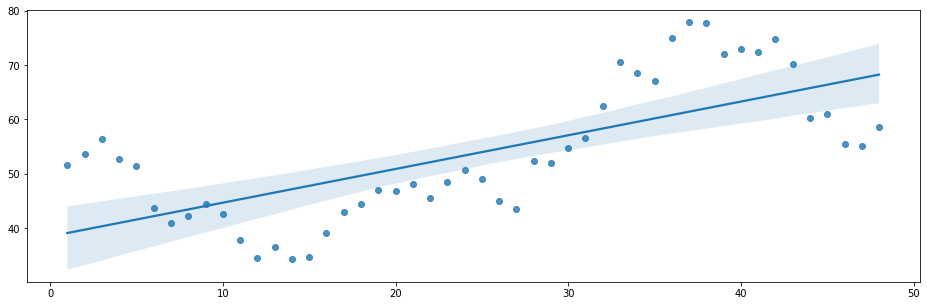

In [ ]:
plt.figure(figsize=(16, 5))
sns.regplot(x=t, y=y, data= df) # мы видим сезонные колебания - колебания в пределах 4 лет
                                # есть возрастающий тренд

In [ ]:
# окончательная модель = трендовая составляющая + сезонная составляющая + случайная составляющая

**лаг сезонности** - промежуток времени между двумя пиковыми значениями

**4.	Определите лаг сезонности с помощью коррелограммы. Воспользуйтесь функцией autocorrelation_plot() из модуля pandas.plotting. Запишите предполагаемое число.**

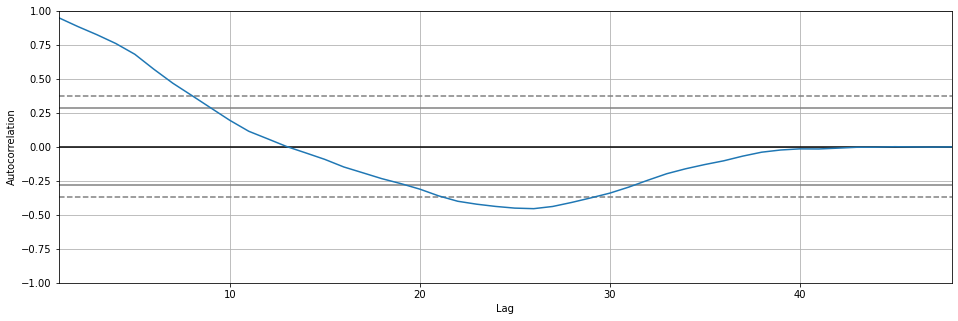

In [ ]:
plt.figure(figsize=(16, 5))
autocorrelation_plot(y)
plt.show()

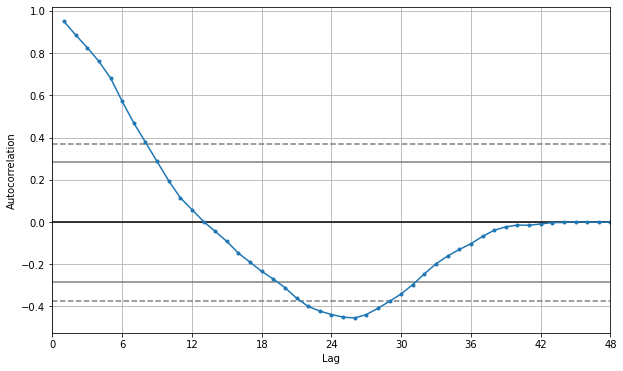

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6)) # лаг сезонности похоже = 12

autocorrelation_plot(y, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(6))
ax.set_xlim(0, 48)

plt.show()

**5.	Разделите исходные данные на обучающий набор (36 наблюдений) и тестовый набор (12 наблюдений). Для этого создайте переменную y, в которую запишите значения временного ряда, обратившись к параметру values. Затем создайте переменную y_train, содержащую обучающую выборку и переменную y_test, содержащую тестовый набор. Выведите на экран объем обучающей и тестовой выборки.**

In [ ]:
df.shape

(48, 1)

In [ ]:
train_size=36

In [ ]:
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [ ]:
len(y_train)

36

In [ ]:
len(y_test)

12

**6.	Запишите в переменную series_train объект Series, содержащий тестовую выборку. Для этого нужно взять срез объекта series. Выведите на экран первые 5 наблюдений.**

In [ ]:
series_train = series[0:train_size]
series_train.shape

(36,)

# **Начинаем строить модель сезонных колебаний !!!!! :**

1. Оценивается сезонная составляющая с учетом характера сезонности

2. Сезонная составляющая убирается из исходных данных

3. Оценивается тренд

4. Собираются в единую модель тендовая и сезонная составляющие, оценивается адекватность этой модели

5. Использование данной модели для прогнозирования

# **1.**

1.1 Сглаживаем временной ряд (с помощью скользящей средней)

1.2 Из исходного ряда исключаем выровненный ряд(отражает эффект сезонности и случайности), т.е.из исходного ряда исключается сезонная составвляющаая и случайная

**7.	Проведите сглаживание временного ряда, записанного в переменной series_train, с помощью процедуры скользящей средней для предварительного оценивания тенденции развития. Воспользуйтесь последовательностью функций rolling().mean(). Ширину окна возьмите равной лагу сезонности. Результат запишите в переменную rolling_mean. Выведите на экран первые 20 наблюдений.**

**1.СГЛАЖИВАЕМ :**

In [ ]:
# т.е. после сглаживания мы получаем тренд, Т.Е.  rolling_mean - это тренд

In [ ]:
rolling_mean=series_train.rolling(window=12).mean() # окно=12, т.к. лаг сезонности = 12
rolling_mean.head(20)

Date
2018-01-31      NaN
2018-02-28      NaN
2018-03-31      NaN
2018-04-30      NaN
2018-05-31      NaN
2018-06-30      NaN
2018-07-31      NaN
2018-08-31      NaN
2018-09-30      NaN
2018-10-31      NaN
2018-11-30      NaN
2018-12-31    46.03
2019-01-31    44.76
2019-02-28    43.14
2019-03-31    41.33
2019-04-30    40.21
2019-05-31    39.51
2019-06-30    39.56
2019-07-31    40.05
2019-08-31    40.44
Name: Close, dtype: float64

**8.	Постройте диаграмму, на которую поместите исходные данные и сглаженный ряд, нарисованный красным цветом. Воспользуйтесь функцией plot() для исходного и сглаженного ряда, а также функцией show() из модуля matplotlib.pyplot.**

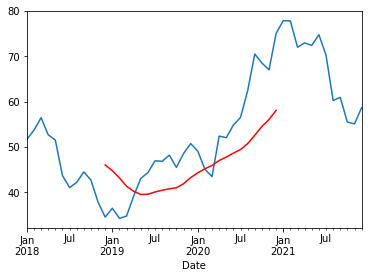

In [ ]:
series.plot() # выделили тренд
rolling_mean.plot(color='red') # первых нет потому что окно =12, выпадают, а последних нет, т.к. они ушли в тестовый набор
plt.show()

**2. ИЗ СИНЕГО РЯДА ВЫЧТЕМ КРАСНЫЙ и получим сезонную составляющую и случайную составляющую :**

**9. Рассчитайте уровни ряда x_t, которые отражают эффект сезонности и случайности. Результат запишите в переменную X. Выведите на экран первые 20 наблюдений.**

In [ ]:
X=y_train-rolling_mean # СОДЕРЖИТ СЕЗОННОСТЬ И СЛУЧАЙНОСТЬ
X.head(20)

Date
2018-01-31      NaN
2018-02-28      NaN
2018-03-31      NaN
2018-04-30      NaN
2018-05-31      NaN
2018-06-30      NaN
2018-07-31      NaN
2018-08-31      NaN
2018-09-30      NaN
2018-10-31      NaN
2018-11-30      NaN
2018-12-31   -11.51
2019-01-31    -8.29
2019-02-28    -8.89
2019-03-31    -6.59
2019-04-30    -1.03
2019-05-31     3.54
2019-06-30     4.79
2019-07-31     6.87
2019-08-31     6.38
Name: Close, dtype: float64

In [ ]:
X.shape

(36,)

**3. ЧИСТИМ ОТ СЛУЧАЙНЫХ ЗНАЧЕНИЙ, очищаем сезонную составляющую**

**10.	 Для элиминирования влияния случайных факторов определите предварительные значения сезонной составляющей, как средние значения из уровней x_t для одноименных месяцев. Результаты представьте в виде таблицы, где в строках представлены данные за одноименный месяц по 3-м годам. Это потребует выполнения следующих действий:**

**10.1	Импортируйте функции DataFrame и Grouper из модуля pandas.**

**10.2	Сгруппируйте временной ряд x_t, полученный в п.9, по годам с помощью функции groupby(Grouper(freq='A')) и поместите результат в переменную groups.**

**10.3	Создайте пустую таблицу данных с помощью функции DataFrame() и поместите результат в переменную years.**

**10.4	С помощью команды for, перебирая период (name) и данные (group), содержащиеся в переменной groups, создайте в таблице данных years столбцы для каждого года (name.year), заполненные соответствующими данными ряда x_t (group.values).**

**10.5	Создайте в таблице данных years столбец mean, содержащий среднее арифметическое сезонных коэффициентов (x ̅_i). Для этого примените к таблице years функцию mean(axis=1).**


In [ ]:
groups=X.groupby(Grouper(freq='A'))

In [ ]:
groups

In [ ]:
years=pd.DataFrame()

In [ ]:
for name, group in groups:
  years[name.year]=group.values

In [ ]:
years['mean']=years.mean(axis=1) # делает столбец в который выводится среднее в строке, т.е. за 3 года
years.shape

(12, 4)

In [ ]:
years

,2018,2019,2020,mean
0,NaN,-8.29,4.78,-1.75
1,NaN,-8.89,-0.12,-4.51
2,NaN,-6.59,-2.44,-4.51
3,NaN,-1.03,5.37,2.17
4,NaN,3.54,4.28,3.91
5,NaN,4.79,6.19,5.49
6,NaN,6.87,7.09,6.98
7,NaN,6.38,11.65,9.02
8,NaN,7.42,17.90,12.66
9,NaN,4.50,14.00,9.25


**11. Рассчитайте среднее значение по столбцу mean, воспользовавшись функцией mean(). Запишите содержимое в переменную k. Выведите ее значение на экран.**

In [ ]:
k=years['mean'].mean() # среднее по столбцу 'mean', т.к. среднее отличается от 0, то и сумма отличается
                       # от 0, а значит нужно вносить поправки
k

4.3205632923058905

**12	Проведите корректировку первоначальных значений сезонной составляющей, вызванную тем, что суммарное воздействие сезонности на динамику предполагается нейтральным. Окончательные оценки коэффициентов сезонности S_i находятся по следующей формуле:**

**12.1	В случае аддитивной тренд-сезонной модели: S_i=x ̅_i-k (i= 1,2,…,m); k=1/m ∑_(t=1)^m▒x ̅_i ;**

**12.2	В случае мультипликативной тренд-сезонной модели: S_i= x ̅_i k (i= 1,2,…,m); k=m/(∑_(i=1)^m▒x ̅_i ), **
**где m – число фаз в полном сезонном цикле (m =12 для рядов месячной динамики).**
**Запишите найденные оценки коэффициентов сезонности S_i в столбец 'S' таблицы years. Выведите содержимое таблицы на экран.**


**4. В СТОЛБЦЕ 'S' НАХОДИТСЯ ОЧИЩЕННАЯ СЕЗОННАЯ СОСТАВЛЯЮЩАЯ**

In [ ]:
years['S']=years['mean']-k # проводим корректировку, т.е. создаем столбец с корректированными данными
years

,2018,2019,2020,mean,S
0,NaN,-8.29,4.78,-1.75,-6.07e+00
1,NaN,-8.89,-0.12,-4.51,-8.83e+00
2,NaN,-6.59,-2.44,-4.51,-8.83e+00
3,NaN,-1.03,5.37,2.17,-2.15e+00
4,NaN,3.54,4.28,3.91,-4.11e-01
5,NaN,4.79,6.19,5.49,1.17e+00
6,NaN,6.87,7.09,6.98,2.66e+00
7,NaN,6.38,11.65,9.02,4.70e+00
8,NaN,7.42,17.90,12.66,8.34e+00
9,NaN,4.50,14.00,9.25,4.93e+00


**5. Т.К. У НАС ЗАНЧЕНИЙ 'S' 12 ШТУК В СТОЛБЦЕ, А НАДО 36, ТО ПОВТОРЯЕМ СТОЛБЕЦ 3 РАЗА**

**13.	 Запишите содержимое столбца 'S' таблицы years в переменную s.**

In [ ]:
s=years['S']

**14.	Повторите 3 раза содержимое переменной s с помощью метода спискового включения: [s for i in range(3)]. Далее создайте временной ряд сезонных коэффициентов, соединив созданные списки в объект Series с помощью функции concat([s for i in range(3)], ignore_index = True). Результат запишите в переменную sez.**

**15.	Индекс объекта sez сделайте таким же, как и у ряда series_train. Для этого достаточно обратиться к параметру index этих временных рядов. Выведите на экран первые 5 наблюдений.**

In [ ]:
sez=pd.concat([s for i in range(3)], ignore_index = True) # т.е. получилиряд с сезонными составляющими
sez.index=series_train.index
sez.head()

Date
2018-01-31   -6.07
2018-02-28   -8.83
2018-03-31   -8.83
2018-04-30   -2.15
2018-05-31   -0.41
Name: S, dtype: float64

**16. Проведите десезонализацию (сезонную корректировку) исходных данных по следующей формуле:**

**16.1	В случае аддитивной тренд-сезонной модели: y ̀_i=y_i-S_i;**

**16.2	В случае мультипликативной тренд-сезонной модели: y ̀_i=y_i/S_i .**

**Рассчитанное значение временного ряда y ̀_i запишите в переменную y_des. Выведите на экран первые 5 наблюдений.**


In [ ]:
#  ВЫЧИТАЕМ ИЗ ТРЕНИРОВОЧНОГО НАБОРА (36ШТ.) - СЕЗОННУЮ СОСТАВЛЯЮЩУЮ = ТРЕНД+СТУЧАЙНАЯ СОСТАВЛЯЮЩАЯ

**y_des** - это ряд по котрому можно строить модель сезонных колебаний

In [ ]:
y_des=y_train-sez
y_des.head()

Date
2018-01-31    57.72
2018-02-28    62.50
2018-03-31    65.27
2018-04-30    54.82
2018-05-31    51.90
Name: S, dtype: float64

**17.	 Запишите в переменную t_train номера наблюдений обучающего набора. Это первые 36 наблюдений. Сгенерировать номера наблюдений можно с помощью функции arange из модуля numpy. Выведите их на экран.**

In [ ]:
x_train = np.arange(1, len(y_des)+1)
x_train

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

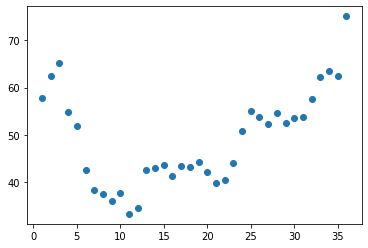

In [ ]:
plt.scatter(x_train,y_des)
plt.show()

**18. Рассчитайте значения параметров тренда (а_0,а_1) на основе временного ряда, полученного в п.16 (для значений y ̀_i). При этом вы можете воспользоваться любым методом, обсуждаемым в задании 4. Например, функцией polyfit(t_train, y_des, deg = 1) из модуля numpy. Результат запишите в переменную coef. Здесь coef[0] – коэффициент при переменой, coef[1] – свободный член. Выведите на экран полученный результат.**

In [ ]:
coef=np.polyfit(x_train, y_des, deg=1)
coef

array([ 0.40022819, 41.69763124])

**РАЗЪЯСНЕНИЕ:** значения coef - это значения свободных членов для уравнения прямой

**у = -0.01000252 * х + 4.64115774**

**19.	 Запишите в переменную t_test номера наблюдений тестового набора. Это наблюдения с 37 по 48. Сгенерировать номера наблюдений можно с помощью функции arange из модуля numpy. Выведите их на экран.**

In [ ]:
t_test = np.arange(len(y_train)+1, len(y)+1)
t_test

array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

**20.	Найдите расчетные значения на тестовом наборе по уравнению тренд-сезонной модели:**

**20.1	В случае аддитивной тренд-сезонной модели:**

**y ̃_t=a_0+a_1 t+S_t**

**20.2	В случае мультипликативной тренд-сезонной модели:**

**y ̃_t=(a_0+a_1 t)S_t**

**Рассчитанные значения по модели запишите в переменную y_pred.**


In [ ]:
y_pred=coef[0]*t_test+coef[1]+s # s- это сезонная составляющая, а остальные 2(тренд+случайная) уже включены, на них обучали
y_pred

0     50.43
1     48.08
2     48.47
3     55.56
4     57.70
5     59.67
6     61.57
7     64.01
8     68.05
9     65.04
10    65.00
11    60.91
Name: S, dtype: float64

**21.	Оцените точность модели на тестовой выборке на основе коэффициента детерминации, воспользовавшись функцией r2_score() из модуля sklearn.metrics. Запишите результат.**

In [ ]:
R2=r2_score(y_test, y_pred)
R2

-2.9859932058195593

**22.	Оцените точность модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

272.01605633743816

# **КОНЕЦ**

**23.	Рассчитайте прогнозные значения на тестовой выборке по базовой модели, которая в качестве прогноза выдает прошлое значение. Результат запишите в переменную y_pred.**

In [ ]:
# Прогноз по базовой модели
y_pred=y[len(y_train)-1:len(y)-1]
y_pred

array([75.04318182, 77.83263158, 77.77105263, 71.97636364, 72.92714286,
       72.3685    , 74.73545455, 70.24047619, 60.23      , 60.91380952,
       55.46190476, 55.08      ])

**24.	Оцените точность базовой модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics. Сравните результат с аналогичным показателем тренд-сезонной модели.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred) # MSE базовой модели намного лучше, значит наша модель плоха
MSE

17.634688870144945

# **Строим тренд-сезонную модель на всех данных**

**25.	Постройте на всех данных лучшую модель. Если это тренд-сезонная модель, то см. пп.7-18.**

In [ ]:
rolling_mean=series.rolling(window=12).mean()
rolling_mean.head(20)

Date
2018-01-31      NaN
2018-02-28      NaN
2018-03-31      NaN
2018-04-30      NaN
2018-05-31      NaN
2018-06-30      NaN
2018-07-31      NaN
2018-08-31      NaN
2018-09-30      NaN
2018-10-31      NaN
2018-11-30      NaN
2018-12-31    46.03
2019-01-31    44.76
2019-02-28    43.14
2019-03-31    41.33
2019-04-30    40.21
2019-05-31    39.51
2019-06-30    39.56
2019-07-31    40.05
2019-08-31    40.44
Name: Close, dtype: float64

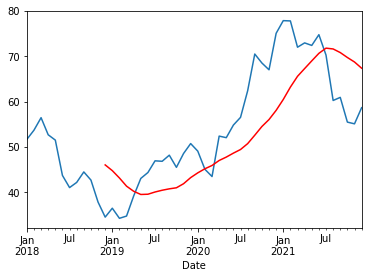

In [ ]:
series.plot()
rolling_mean.plot(color='red')
plt.show()

In [ ]:
X=y-rolling_mean
X.head(20)

Date
2018-01-31      NaN
2018-02-28      NaN
2018-03-31      NaN
2018-04-30      NaN
2018-05-31      NaN
2018-06-30      NaN
2018-07-31      NaN
2018-08-31      NaN
2018-09-30      NaN
2018-10-31      NaN
2018-11-30      NaN
2018-12-31   -11.51
2019-01-31    -8.29
2019-02-28    -8.89
2019-03-31    -6.59
2019-04-30    -1.03
2019-05-31     3.54
2019-06-30     4.79
2019-07-31     6.87
2019-08-31     6.38
Name: Close, dtype: float64

In [ ]:
groups=X.groupby(Grouper(freq='A'))

In [ ]:
years=pd.DataFrame()

In [ ]:
for name, group in groups:
  years[name.year]=group.values

In [ ]:
years['mean']=years.mean(axis=1)
years

,2018,2019,2020,2021,mean
0,NaN,-8.29,4.78,17.38,4.63
1,NaN,-8.89,-0.12,14.59,1.86
2,NaN,-6.59,-2.44,6.42,-0.87
3,NaN,-1.03,5.37,5.66,3.33
4,NaN,3.54,4.28,3.40,3.74
5,NaN,4.79,6.19,4.11,5.03
6,NaN,6.87,7.09,-1.53,4.14
7,NaN,6.38,11.65,-11.36,2.23
8,NaN,7.42,17.90,-9.88,5.15
9,NaN,4.50,14.00,-14.25,1.42


In [ ]:
k=years['mean'].mean()
k

2.75448551461869

In [ ]:
years['S']=years['mean']-k
years

,2018,2019,2020,2021,mean,S
0,NaN,-8.29,4.78,17.38,4.63,1.87
1,NaN,-8.89,-0.12,14.59,1.86,-0.89
2,NaN,-6.59,-2.44,6.42,-0.87,-3.62
3,NaN,-1.03,5.37,5.66,3.33,0.58
4,NaN,3.54,4.28,3.40,3.74,0.99
5,NaN,4.79,6.19,4.11,5.03,2.27
6,NaN,6.87,7.09,-1.53,4.14,1.39
7,NaN,6.38,11.65,-11.36,2.23,-0.53
8,NaN,7.42,17.90,-9.88,5.15,2.39
9,NaN,4.50,14.00,-14.25,1.42,-1.33


In [ ]:
s=years['S']

In [ ]:
sez=pd.concat([s for i in range(4)], ignore_index = True)
sez.index=df.index
sez.head()

Date
2018-01-31    1.87
2018-02-28   -0.89
2018-03-31   -3.62
2018-04-30    0.58
2018-05-31    0.99
Name: S, dtype: float64

In [ ]:
y_des=y-sez
y_des.head()

Date
2018-01-31    49.77
2018-02-28    54.57
2018-03-31    60.06
2018-04-30    52.09
2018-05-31    50.51
Name: S, dtype: float64

In [ ]:
t = np.arange(1, len(y_des)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [ ]:
coef=np.polyfit(t, y_des, deg=1)
coef

array([ 0.62496366, 38.35183607])

In [ ]:
y_pred=coef[0]*t+coef[1]+sez
y_pred.head()

Date
2018-01-31    40.85
2018-02-28    38.71
2018-03-31    36.60
2018-04-30    41.43
2018-05-31    42.46
Name: S, dtype: float64

**26.	Оцените точность модели для всех данных с помощью следующих показателей: коэффициента детерминации, MAE, MSE, RMSE. Соответствующие функции приведены в задании 4. Прокомментируйте полученные результаты.**

In [ ]:
R2=r2_score(y,y_pred)
R2

0.4864375291950438

In [ ]:
MAE=mean_absolute_error(y,y_pred) # низкий показатель, хороший
MAE

7.734572556944233

In [ ]:
MSE=mean_squared_error(y,y_pred) # низкий показатель, хороший
MSE

79.04064158808539

In [ ]:
RMSE=sqrt(MSE) # низкий показатель, хороший
RMSE

8.890480391299752

**27.	Рассчитайте ошибки модели для всех данных. Поместите столбец ошибок 'Error' в таблицу исходных данных. Выведите на экран первые 5 наблюдений.**

In [ ]:
df['Error']=y-y_pred
df.head()

,Close,Error
Date,,
2018-01-31,51.64,10.80
2018-02-28,53.67,14.97
2018-03-31,56.44,19.83
2018-04-30,52.67,11.24
2018-05-31,51.49,9.03


**28.	Постройте линейный график ошибок, воспользовавшись функциеями plot() и show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

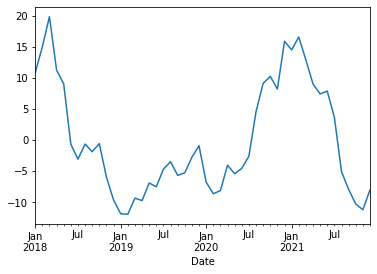

In [ ]:
df.Error.plot()
plt.show()

**29.	Выведите на экран описательные статистики ошибок, воспользовавшись функцией describe(). Прокомментируйте результат.**


In [ ]:
df.Error.describe()

count    4.80e+01
mean     3.70e-15
std      8.98e+00
min     -1.20e+01
25%     -7.07e+00
50%     -2.93e+00
75%      8.39e+00
max      1.98e+01
Name: Error, dtype: float64

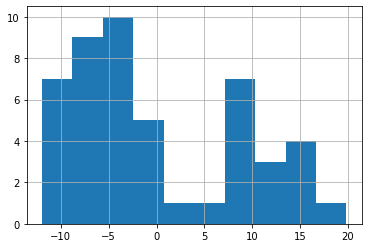

In [ ]:
df.Error.hist()
plt.show()

**30.	Постройте для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

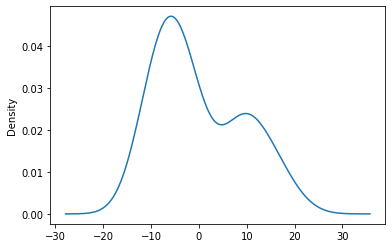

In [ ]:
df.Error.plot(kind='kde')
plt.show()

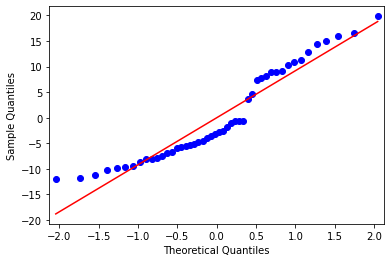

In [ ]:
qqplot(df.Error,line='r')
plt.show()

**31.	Оцените адекватность тренд-сезонной модели на основе теста Дарбина-Уотсона, воспользовавшись функцией durbin_watson() из модуля statsmodels.stats.stattools применительно к остаткам модели. Прокомментируйте результат.**

In [ ]:
d=durbin_watson(df.Error)
d

0.17655988412655493

In [ ]:
4-d

3.8234401158734452

n=48, k=1, alfa=0.05. Для n=50 и k=1, alfa=0.05 dl=1.5, du=1.59.
**4-d>du, поэтому гипотеза об отсутствии автокорреляции не отвергается.**

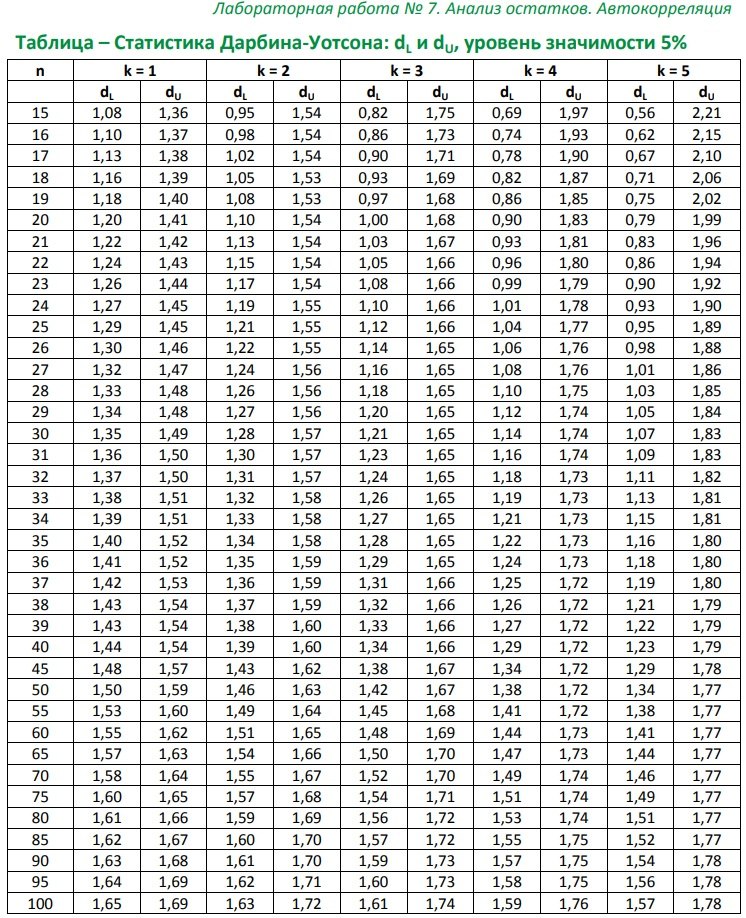

**32.	Постройте для ошибок тренд-сезонной модели коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting. Прокомментируйте результат.**

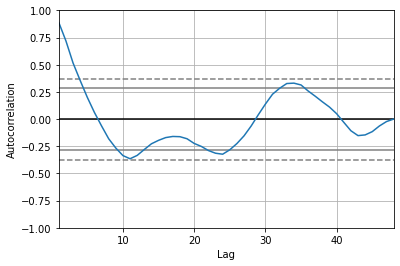

In [ ]:
autocorrelation_plot(df.Error)  # автокорреляциия
plt.show()

**33.	На основе переменной y рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma =scipy.stats.sem(y)
sigma

1.8095878000202659

**34.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
confidence=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0117405104757546

**35.	Сгенерируйте номера наблюдений для прогнозного интервала, равного 12 месяцев (с 49 по 60 наблюдение). Запишите результат в переменную t_new и выведите его на экран.**

In [ ]:
t_new =np.arange(len(y)+1, len(y)+13)
t_new

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

**36.	Найдите прогнозные значения цены на материал 2 на год вперед (точечный прогноз). Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new = coef[0]*t_new+coef[1]+s
y_new

0     70.85
1     68.71
2     66.60
3     71.43
4     72.46
5     74.37
6     74.11
7     72.82
8     76.37
9     73.27
10    73.80
11    74.16
Name: S, dtype: float64

**37.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

0     74.49
1     72.35
2     70.24
3     75.07
4     76.10
5     78.02
6     77.75
7     76.46
8     80.01
9     76.91
10    77.44
11    77.80
Name: S, dtype: float64

**38.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

0     67.21
1     65.06
2     62.96
3     67.79
4     68.82
5     70.73
6     70.47
7     69.18
8     72.73
9     69.62
10    70.16
11    70.52
Name: S, dtype: float64

**39.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.**

In [ ]:
i= list(np.arange(49,53))
i

[49, 50, 51, 52]

In [ ]:
j= list(series_2022.values)

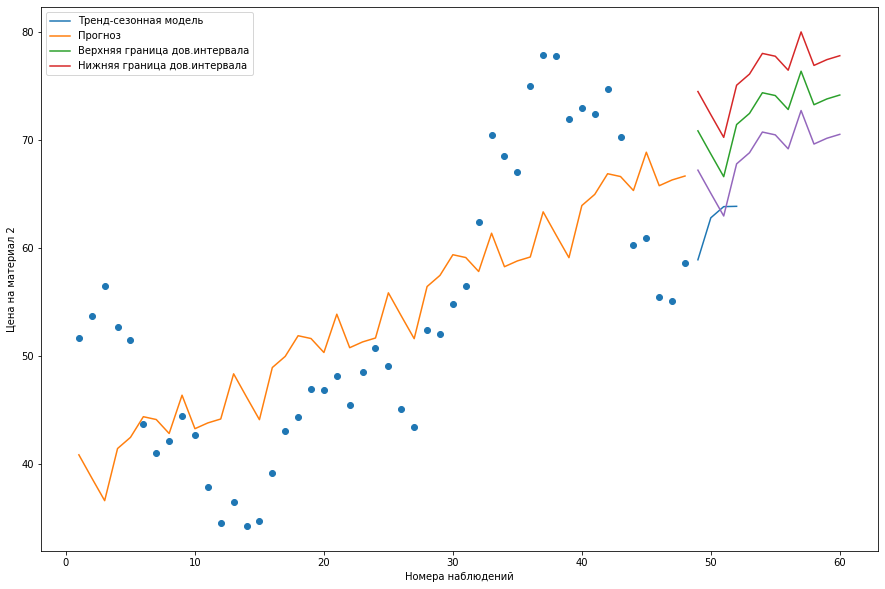

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(t,y)

plt.plot(i,j)
plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel('Номера наблюдений')
plt.ylabel('Цена на материал 2')
plt.legend(['Тренд-сезонная модель','Прогноз','Верхняя граница дов.интервала','Нижняя граница дов.интервала'])

plt.show()

**40.	Проведите декомпозицию временного ряда с помощью функции seasonal_decompose(series, model='additive') из модуля statsmodels.tsa.seasonal. Результат запишите в переменную result.**

In [ ]:
result=seasonal_decompose(series, model='additive')

**41.	Выведите на экран полученный результат с помощью функций plot() и show() из модуля matplotlib.pyplot.**

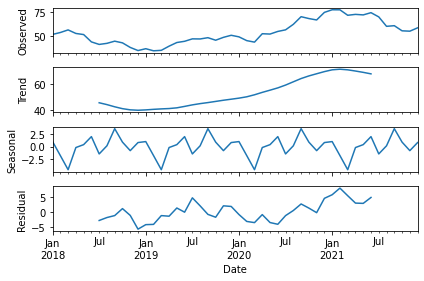

In [ ]:
result.plot() # 1-фактическая составляющая
              # 2-тренд
              # 3-сезонная составляющая
              # 4-ошибки
plt.show()

**42.	Трендовая составляющая содержится в параметре trend. Выведите на экран первые 10 наблюдений.**

In [ ]:
result.trend.head(10)

Date
2018-01-31      NaN
2018-02-28      NaN
2018-03-31      NaN
2018-04-30      NaN
2018-05-31      NaN
2018-06-30      NaN
2018-07-31    45.39
2018-08-31    43.95
2018-09-30    42.24
2018-10-31    40.77
Name: Close, dtype: float64

**43.	Сезонная составляющая содержится в параметре seasonal. Выведите на экран первые 5 наблюдений.**

In [ ]:
result.seasonal.head()

Date
2018-01-31    0.99
2018-02-28   -1.76
2018-03-31   -4.54
2018-04-30   -0.18
2018-05-31    0.39
Name: Close, dtype: float64

**44.	Остатки содержатся в параметре resid. Выведите на экран первые 10 наблюдений.**

In [ ]:
result.resid.head(10)

Date
2018-01-31     NaN
2018-02-28     NaN
2018-03-31     NaN
2018-04-30     NaN
2018-05-31     NaN
2018-06-30     NaN
2018-07-31   -2.93
2018-08-31   -1.95
2018-09-30   -1.30
2018-10-31    1.03
Name: Close, dtype: float64

# **ЗАДАНИЕ 6. ПРИМЕНЕНИЕ ФИКТИВНЫХ ПЕРЕМЕННЫХ ДЛЯ МОДЕЛИРОВАНИЯ СЕЗОННЫХ КОЛЕБАНИЙ**

Постройте тренд-сезонную модель, описывающую ряд данных по ценам на материал 2. Для описания сезонных колебаний используйте фиктивные переменные. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.

Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot
import scipy.stats
import seaborn as sns
from sklearn.linear_model import LinearRegression

**1.	Прочитайте данные по ценам на материал 2 и приведите их к виду, пригодному для дальнейшего анализа (см. пп.1-10 Задания 1).**

# **1.ГОТОВИМ ДАННЫЕ ДЛЯ РЕГРЕССИИ**

__________________________________________

# **ДАТАСЕТ**

In [ ]:
df=data[['Date','Close']]

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df = df.drop(df.index[[300,550,551,800]])

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df=df.set_index('Date')

In [ ]:
series=df.squeeze() # переводим DataFrame в Series для дальнейшей работы
series.head(5)

Date
2018-01-02    45.90
2018-01-03    46.94
2018-01-04    48.53
2018-01-05    47.43
2018-01-08    47.56
Name: Close, dtype: float64

In [ ]:
series=series.resample('M').mean()

In [ ]:
df = series.reset_index()

In [ ]:
df = df.set_index('Date')

In [ ]:
df.shape

(48, 1)

_________________________________________

**2.	Убедитесь в том, что Вы работаете с объектом Series, а не DataFrame. Превратить таблицу с одним столбцом целевых значений в объект Series можно с помощью функции squeeze(). Дайте ему название series.**

In [ ]:
series=df.squeeze()
type(series)

pandas.core.series.Series

**3.	Посмотрите на динамику временного ряда и его положение относительно линейного тренда визуально с помощью функции regplot(x=x, y=y, data=data) из модуля seaborn. В качестве x возьмите номера наблюдений, а y – значения цены на материал 2. Прокомментируйте результат. Обратите внимание на амплитуду колебаний.**

In [ ]:
y=series.values

In [ ]:
t=np.arange(1,len(y)+1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

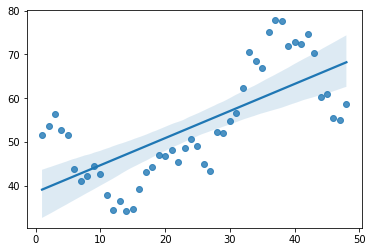

In [ ]:
sns.regplot(x=t, y=y, data= df) # сезонность есть

**4.	Определите лаг сезонности с помощью коррелограммы. Воспользуйтесь функцией autocorrelation_plot() из модуля pandas.plotting. Запишите предполагаемое число.**

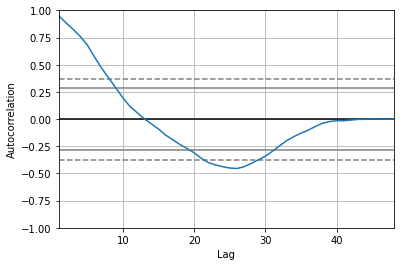

In [ ]:
autocorrelation_plot(y) # лаг сезонности примерно 12 месяцев
plt.show()

**5.	Создайте таблицу данных с названием dataframe, в которой в качестве столбцов представлены месяц ('month'), год ('year'), цена ('price') и номер наблюдения ('t'). При создании столбцов для года и месяца воспользуйтесь соответственно параметрами month и year индекса временного ряда series, встроенных в списковое включение с циклом for.**

Код для столбца month: [series.index[i].month for i in range(len(series))].

Код для столбца year: [series.index[i].year for i in range(len(series))].

Код для столбца price: [series[i] for i in range(len(series))].
Код для столбца t: np.arange(1, len(series) + 1).

Выведите на экран первые 5 наблюдений, воспользовавшись функцией head().


In [ ]:
dataframe=pd.DataFrame()

In [ ]:
# альтернатива задать столбцы с датами !!!!!!!!!!!!!!!!!!!!!!!!!(это для справки, не использовал)
dataframe['month']=series.index.month
dataframe['year']=series.index.year

In [ ]:
dataframe['month']=[series.index[i].month for i in range(len(series))]

In [ ]:
dataframe['year']=[series.index[i].year for i in range(len(series))]

In [ ]:
dataframe['price']=[series[i] for i in range(len(series))]

In [ ]:
dataframe['t']=np.arange(1, len(series) + 1) # номер наблюдения (сквозная нумерация)

In [ ]:
dataframe.head(5)

,month,year,price,t
0,1,2018,51.64,1
1,2,2018,53.67,2
2,3,2018,56.44,3
3,4,2018,52.67,4
4,5,2018,51.49,5


**6.	Установите для столбца 'month' тип данных object, воспользовавшись функцией astype().**

In [ ]:
dataframe.month=dataframe.month.astype(object)

**7.	Создайте фиктивные переменные на основе столбца 'month', применив к таблице dataframe функцию get_dummies() из модуля pandas.**

In [ ]:
dataframe=pd.get_dummies(dataframe)
dataframe.head(10)

,year,price,t,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018,51.64,1,1,0,0,0,0,0,0,0,0,0,0,0
1,2018,53.67,2,0,1,0,0,0,0,0,0,0,0,0,0
2,2018,56.44,3,0,0,1,0,0,0,0,0,0,0,0,0
3,2018,52.67,4,0,0,0,1,0,0,0,0,0,0,0,0
4,2018,51.49,5,0,0,0,0,1,0,0,0,0,0,0,0
5,2018,43.70,6,0,0,0,0,0,1,0,0,0,0,0,0
6,2018,41.03,7,0,0,0,0,0,0,1,0,0,0,0,0
7,2018,42.16,8,0,0,0,0,0,0,0,1,0,0,0,0
8,2018,44.48,9,0,0,0,0,0,0,0,0,1,0,0,0
9,2018,42.68,10,0,0,0,0,0,0,0,0,0,1,0,0


**8.	Число фиктивных переменных должно быть на 1 меньше, чем число категорий, т.е. должно быть 11 фиктивных переменных. Поэтому удалите столбец 'month_1', воспользовавшись функцией pop(). Выведите на экран первые 5 наблюдений.**

In [ ]:
dataframe.pop('month_1') # первый месяц будет базовым
dataframe.head()

,year,price,t,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018,51.64,1,0,0,0,0,0,0,0,0,0,0,0
1,2018,53.67,2,1,0,0,0,0,0,0,0,0,0,0
2,2018,56.44,3,0,1,0,0,0,0,0,0,0,0,0
3,2018,52.67,4,0,0,1,0,0,0,0,0,0,0,0
4,2018,51.49,5,0,0,0,1,0,0,0,0,0,0,0


# **2.ТЕПЕРЬ ВСЕ ГОТОВО ДЛЯ ПОСТРОЙКИ РЕГРЕССИИ**

In [ ]:
dataframe.shape

(48, 14)

**9.	Разделите исходные данные на обучающий набор (36 наблюдений) и тестовый набор (12 наблюдений). Для этого создайте переменную array, в которую запишите значения переменных таблицы dataframe, обратившись к параметру values. Затем создайте переменные x_train и y_train, содержащие данные обучающей выборки, а также переменные x_test и y_test с данными тестовой выборки. Выведите на экран объем обучающей и тестовой выборки.**

In [ ]:
array=dataframe.values

In [ ]:
x_train=array[0:36,2:14]

In [ ]:
y_train=array[0:36,1]

In [ ]:
x_test =array[36:48,2:14]

In [ ]:
y_test =array[36:48,1]

**10.	Создайте модель линейной регрессии, воспользовавшись функцией LinearRegression() из модуля sklearn.linear_model. Обучите на обучающей выборке модель линейной регрессии, воспользовавшись функцией fit(). Результат запишите в переменную model.**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model=LinearRegression().fit(x_train,y_train)

**11.	Выведите на экран свободный член модели линейной регрессии, обратившись к ее параметру intercept_.**

In [ ]:
model.intercept_ # это данные для справки, все уже вшито в model

39.209260678458335

**12.	Выведите на экран коэффициенты при независимых переменных в модели линейной регрессии, обратившись к ее параметру coef_.**

In [ ]:
model.coef_ # это данные для справки, все уже вшито в model

array([ 0.50126566, -1.9008396 , -1.84603132,  0.84318714,  1.1245261 ,
       -0.61147766, -0.5812592 ,  1.21686689,  4.6360656 ,  1.98265101,
        0.37808941,  2.18834968])

ПОЛУЧИЛИ УРАВНЕНИЕ: **y = 4.4066666 - 0.01 * x - 0.18666667*x2 - ...........**

**13.	Найдите расчетные значения результативного признака по модели линейной регрессии на тестовом наборе, воспользовавшись функцией predict(x_test). Результат запишите в переменную y_pred. Выведите на экран ее содержимое.**

In [ ]:
y_pred=model.predict(x_test) # прагноз для тестовой выборки
y_pred

array([57.75609018, 56.35651624, 56.91259018, 60.1030743 , 60.88567892,
       59.65094083, 60.18242495, 62.4818167 , 66.40228107, 64.25013215,
       63.14683621, 65.45836214])

**14.	Оцените точность модели на тестовой выборке на основе коэффициента детерминации, воспользовавшись функцией r2_score(y_test, y_pred) из модуля sklearn.metrics. Запишите результат.**

In [ ]:
R2=r2_score(y_test, y_pred) # фсё
R2

-1.366004360793982

**15.	Оцените точность модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics. Запишите результат.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

161.4631892901161

**18.	Постройте на всех данных лучшую модель. Если это тренд-сезонная модель, то сделать это надо по аналогии с пп.9-12.**

In [ ]:
x=array[:,2:14]
y=array[:,1]

In [ ]:
model=LinearRegression().fit(x,y)

In [ ]:
model.intercept_

41.27579779058979

In [ ]:
model.coef_

array([ 0.65666557, -1.72174076, -3.41002312, -1.43613079, -1.64550361,
       -2.63648412, -4.01828118, -5.45302199, -2.9983869 , -6.63214035,
       -8.21175406, -6.24443427])

In [ ]:
y_pred=model.predict(x)
y_pred

array([41.93246336, 40.86738817, 39.83577137, 42.46632927, 42.91362202,
       42.57930709, 41.8541756 , 41.07610036, 44.18740102, 41.21031314,
       40.28736499, 42.91135035, 49.81245019, 48.747375  , 47.71575821,
       50.34631611, 50.79360886, 50.45929392, 49.73416243, 48.95608719,
       52.06738785, 49.09029997, 48.16735182, 50.79133718, 57.69243703,
       56.62736184, 55.59574504, 58.22630294, 58.67359569, 58.33928075,
       57.61414926, 56.83607402, 59.94737468, 56.9702868 , 56.04733865,
       58.67132402, 65.57242386, 64.50734867, 63.47573187, 66.10628977,
       66.55358252, 66.21926759, 65.49413609, 64.71606085, 67.82736151,
       64.85027363, 63.92732549, 66.55131085])

**19.	Оцените точность модели для всех данных с помощью следующих показателей: коэффициента детерминации, MAE, MSE, RMSE. Соответствующие функции приведены в задании 4. Прокомментируйте полученные результаты.**

In [ ]:
R2=r2_score(y, y_pred)
R2

0.5135825235678912

In [ ]:
MSE=mean_squared_error(y, y_pred)
MSE

74.86284844098901

In [ ]:
MAE=mean_absolute_error(y, y_pred)
MAE

7.3774056015780545

In [ ]:
RMSE=sqrt(MSE)
RMSE

8.65233196548705

**20.	Рассчитайте ошибки модели для всех данных. Поместите столбец ошибок 'Error' в таблицу исходных данных. Выведите на экран первые 5 наблюдений.**

In [ ]:
df['Error']=y-y_pred
df.head()

,Close,Error
Date,,
2018-01-31,51.64,9.71
2018-02-28,53.67,12.81
2018-03-31,56.44,16.60
2018-04-30,52.67,10.20
2018-05-31,51.49,8.58


**21.	Постройте линейный график ошибок, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

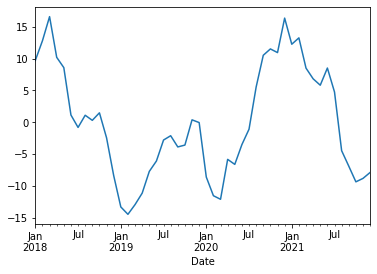

In [ ]:
df.Error.plot()
plt.show()

**22.	Выведите на экран описательные статистики ошибок, воспользовавшись функцией describe(). Прокомментируйте результат.**

In [ ]:
df.Error.describe()

count    4.80e+01
mean     5.33e-15
std      8.74e+00
min     -1.45e+01
25%     -7.12e+00
50%     -9.68e-01
75%      8.50e+00
max      1.66e+01
Name: Error, dtype: float64

**23.	Постройте для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из matplotlib.pyplot. Прокомментируйте результат.**

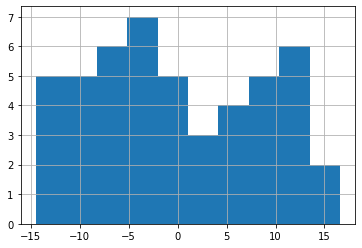

In [ ]:
df.Error.hist()
plt.show()

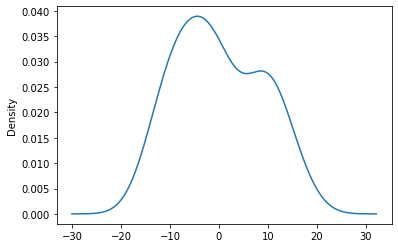

In [ ]:
df.Error.plot(kind='kde')
plt.show()

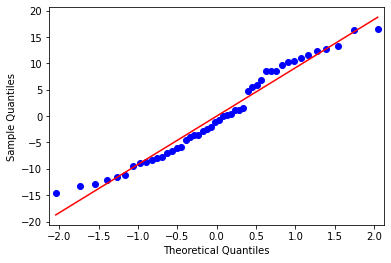

In [ ]:
qqplot(df.Error,line='r')
plt.show()

In [ ]:
d=durbin_watson(df.Error)
d

0.18415071040696462

In [ ]:
4-d

3.8158492895930354

n=48, k=1, alfa=0.05. Для n=50 и k=1, alfa=0.05 dl=1.5, du=1.59.
4-d>du, поэтому гипотеза об отсутствии автокорреляции не отвергается.

**24.	Постройте для ошибок модели коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting. Прокомментируйте результат.**

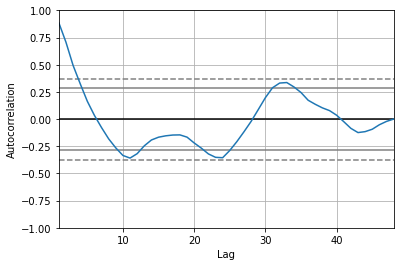

In [ ]:
autocorrelation_plot(df.Error)
plt.show()

**25.	Рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma =scipy.stats.sem(y)
sigma

1.8095878000202659

**26.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
confidence=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0117405104757546

**27.	Сгенерируйте номера наблюдений для прогнозного интервала, равного 12 месяцев, - с 49 по 60 наблюдение. Результат представьте в виде столбца. Для этого воспользуйтесь функцией reshape(-1,1) . Запишите результат в переменную t_new и выведите его на экран.**

In [ ]:
t_new =np.arange(len(y)+1, len(y)+13)
t_new

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [ ]:
t_new=t_new.reshape(-1,1)
t_new

array([[49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60]])

**28.	Подготовьте значения фиктивных переменных для прогнозного интервала, равного 1 году в помесячной разбивке. Запишите результат в переменную d и выведите его на экран.**

In [ ]:
d=array[0:12,3:14]
d

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

**29.	Создайте на основе переменных t_new и d объекты DataFrame - df_t_new и df_d, воспользовавшись функцией DataFrame() из модуля pandas.**

In [ ]:
df_t_new =pd.DataFrame(t_new)

In [ ]:
df_d=pd.DataFrame(d)

**30.	Объедините их, воспользовавшись функцией concat([df_t_new,df_d],axis=1,names=['t', 'd2','d3','d4','d5','d6','d7','d8','d9','d10','d11','d12']) из модуля pandas. Запишите результат в переменную x_new и выведите его на экран.**

In [ ]:
x_new=pd.concat([df_t_new,df_d],axis=1,names=['t', 'd2','d3','d4','d5','d6','d7','d8','d9','d10','d11','d12'])
x_new

,0,0,1,2,3,4,5,6,7,8,9,10
0,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,53,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,54,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,55,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,56,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**31.	Найдите прогнозные значения цены на материал 2 на год вперед (точечный прогноз), воспользовавшись функцией predict() модели линейной регрессии. Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new =model.predict(x_new)
y_new

array([73.45241069, 72.3873355 , 71.35571871, 73.98627661, 74.43356935,
       74.09925442, 73.37412293, 72.59604769, 75.70734835, 72.73026047,
       71.80731232, 74.43129768])

**32.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

array([77.09283178, 76.02775659, 74.99613979, 77.62669769, 78.07399044,
       77.7396755 , 77.01454401, 76.23646877, 79.34776943, 76.37068155,
       75.4477334 , 78.07171877])

**33.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

array([69.81198961, 68.74691442, 67.71529762, 70.34585552, 70.79314827,
       70.45883333, 69.73370184, 68.9556266 , 72.06692726, 69.08983938,
       68.16689124, 70.7908766 ])

**34.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.**

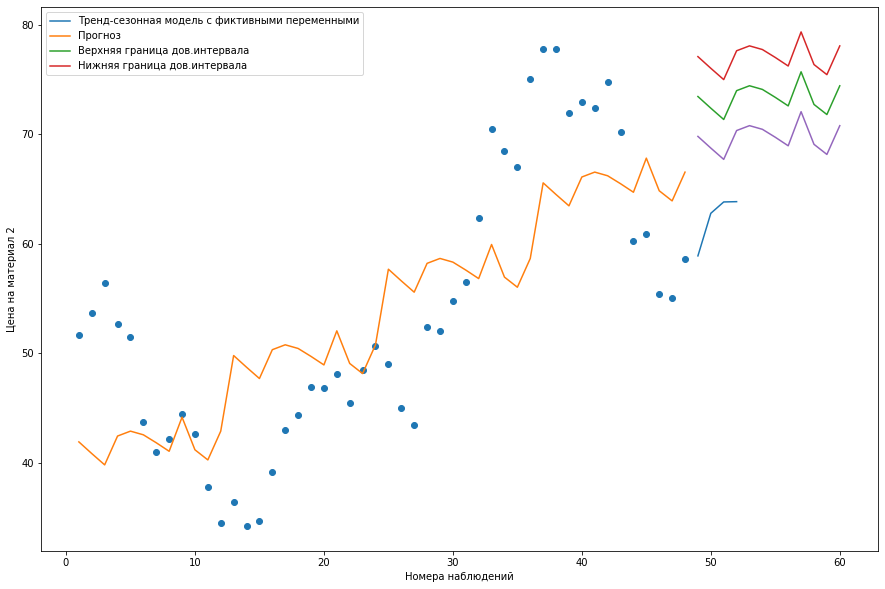

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(t,y)

#plt.plot(i,j)
plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel('Номера наблюдений')
plt.ylabel('Цена на материал 2')
plt.legend(['Тренд-сезонная модель с фиктивными переменными','Прогноз','Верхняя граница дов.интервала','Нижняя граница дов.интервала'])

plt.show()

# **ЗАДАНИЕ 7. ПОСТРОЕНИЕ МОДЕЛИ АВТОРЕГРЕССИИ**
Рассчитайте коэффициенты автокорреляции для временного ряда цен на материал 3. На их основе определите порядок авторегрессии и постройте соответствующую модель. Рассчитайте показатели точности и адекватности построенной модели. Дайте точечный и интервальный прогнозы на 1 год вперёд по построенной модели.
Постарайтесь максимально автоматизировать все вычисления, использовать существующие модули среды программирования Python.


In [ ]:
!pip install statsmodels --upgrade

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import scipy.stats
from sklearn.linear_model import LinearRegression

__________________________________________

# **ДАТАСЕТ**

In [ ]:
df=data[['Date','Close']]

In [ ]:
df = df[-1082:-74] # выбралданные с 2018 года по 2021 включительно

In [ ]:
df = df.drop(df.index[[300,550,551,800]])

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df=df.set_index('Date')

In [ ]:
series=df.squeeze() # переводим DataFrame в Series для дальнейшей работы
series.head(5)

Date
2018-01-02    45.90
2018-01-03    46.94
2018-01-04    48.53
2018-01-05    47.43
2018-01-08    47.56
Name: Close, dtype: float64

In [ ]:
series=series.resample('M').mean()

In [ ]:
df = series.reset_index()

In [ ]:
df = df.set_index('Date')

In [ ]:
df.shape

(48, 1)

_________________________________________

**2.	Убедитесь в том, что Вы работаете с объектом Series, а не DataFrame. Превратить таблицу с одним столбцом целевых значений в объект Series можно с помощью функции squeeze(). Дайте ему название series.**

In [ ]:
series=df.squeeze()
type(series)

pandas.core.series.Series

**3.	Посмотрите на динамику временного ряда с помощью функций plot() и show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

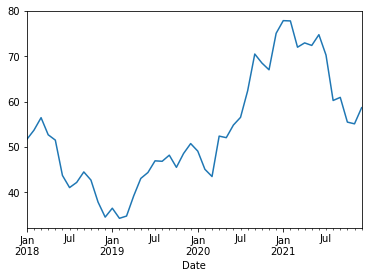

In [ ]:
series.plot()
plt.show()

**4.	Рассчитайте максимальную величину лага (max_tau), как 4-ую часть объема выборки. Выведите результат на экран.**

In [ ]:
max_tau=int(len(series)/4)
max_tau

12

**5.	По ряду цен постройте коррелограмму. Воспользуйтесь функцией autocorrelation_plot() из модуля pandas.plotting.**

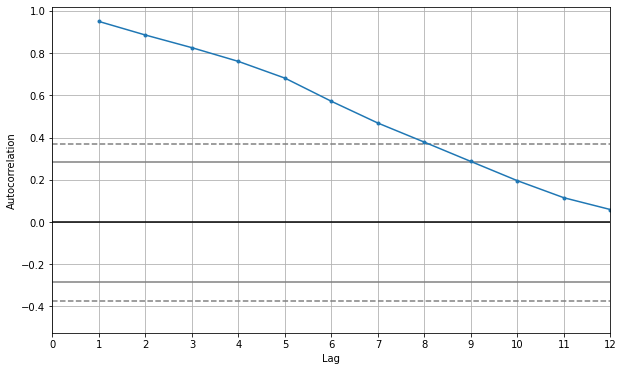

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(series, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, max_tau)

plt.show()

**6.	Для всех значений лага от 1 до max_tau и коэффициентов автокорреляции, вычисленных с помощью функции autocorr(lag=i), по модулю больших 0,8, выведите на экран лаг и значение коэффициента автокорреляции.**

In [ ]:
for i in range(1,max_tau+1):
  if series.autocorr(lag=i)>=0.8 or series.autocorr(lag=i)<=-0.8:
    print('tau=',i, 'r=',series.autocorr(lag=i))

tau= 1 r= 0.9520064711791563
tau= 2 r= 0.8877189207970233
tau= 3 r= 0.828269471090948


**7.	Постройте таблицу данных на основе значений цены на материал 3, воспользовавшись функцией DataFrame() из модуля pandas, результат поместите в переменную values.**

In [ ]:
values=pd.DataFrame(series.values)

**8.	Поместите в переменную dataframe исходный ряд и сдвинутый на x шагов, где x соответствует лагам из п. 6, воспользовавшись функцией concat([values.shift(x), values], axis=1) из модуля pandas.**

In [ ]:
dataframe =pd.concat([values.shift(6),values.shift(5),values.shift(4),values.shift(3),values.shift(2),values.shift(1), values], axis=1)

**9.	Дайте полученным столбцам названия 't' и 't-x', воспользовавшись следующей командой: df.columns = [ 't-x', 't']. Выведите на экран первые 10 значений, воспользовавшись функцией head().**

In [ ]:
dataframe.columns = [ 't-6','t-5','t-4','t-3','t-2','t-1', 't']

In [ ]:
dataframe.head(10)

,t-6,t-5,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,NaN,NaN,51.64
1,NaN,NaN,NaN,NaN,NaN,51.64,53.67
2,NaN,NaN,NaN,NaN,51.64,53.67,56.44
3,NaN,NaN,NaN,51.64,53.67,56.44,52.67
4,NaN,NaN,51.64,53.67,56.44,52.67,51.49
5,NaN,51.64,53.67,56.44,52.67,51.49,43.70
6,51.64,53.67,56.44,52.67,51.49,43.70,41.03
7,53.67,56.44,52.67,51.49,43.70,41.03,42.16
8,56.44,52.67,51.49,43.70,41.03,42.16,44.48
9,52.67,51.49,43.70,41.03,42.16,44.48,42.68


**10.	Создайте переменную array, в которую запишите значения переменных таблицы dataframe, обратившись к параметру values.**

In [ ]:
array=dataframe.values

**11.	Разделите исходные данные на тестовый набор (12 последних наблюдений) и обучающий набор (оставшиеся наблюдения). Для этого создайте переменные x_train и y_train, содержащие данные обучающей выборки и переменные x_test и y_test с данными тестовой выборки. Выведите на экран объем обучающей и тестовой выборки.**

In [ ]:
x_train =array[6:36,0:6]
y_train=array[6:36,6]
x_test =array[36:48,0:6]
y_test =array[36:48,6]

**12.	Создайте модель линейной регрессии, воспользовавшись функцией LinearRegression() из модуля sklearn.linear_model. Обучите на обучающей выборке модель линейной регрессии, воспользовавшись функцией fit(). Результат запишите в переменную model.**

In [ ]:
model=LinearRegression().fit(x_train,y_train)

**13.	Выведите на экран свободный член модели линейной регрессии, обратившись к ее параметру intercept_.**

In [ ]:
model.intercept_

0.6500429335902211

**14.	Выведите на экран коэффициенты при независимых переменных в модели линейной регрессии, обратившись к ее параметру coef_.**

In [ ]:
model.coef_

array([-0.14721298, -0.11806234,  0.18814247,  0.29650471, -0.43077951,
        1.21696407])

**15.	Найдите расчетные значения результативного признака по модели линейной регрессии на тестовом наборе и запишите их в переменную y_pred. Выведите на экран полученный результат.**

In [ ]:
y_pred=model.predict(x_test)
y_pred

array([81.00055194, 78.29143033, 78.16019253, 73.94457261, 77.37483394,
       73.04132464, 74.95078557, 69.16736434, 60.25882997, 64.44183971,
       53.50143792, 53.88684071])

**16.	Оцените точность модели на тестовой выборке на основе средней квадратичной ошибки (MSE), воспользовавшись функцией mean_squared_error(y_test, y_pred) из модуля sklearn.metrics. Запишите результат.**

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

23.811995273966037

In [ ]:
r2_score(y_test, y_pred)

0.6510704086478853

# **СТРОИМ МОДЕЛЬ НА ВСЕХ ДАННЫХ**

**19.	Постройте на всех данных лучшую модель.**

In [ ]:
x=array[6:48,0:6]
y=array[6:48,6]

In [ ]:
model=LinearRegression().fit(x,y)

In [ ]:
model.intercept_

5.387581744910882

In [ ]:
model.coef_

array([-0.3226073 ,  0.16373074,  0.03352204,  0.184656  , -0.22822566,
        1.07147614])

In [ ]:
y_pred=model.predict(x)

**20.	Оцените точность модели для всех данных с помощью следующих показателей: коэффициента детерминации, MAE, MSE, RMSE. Соответствующие функции приведены в задании 4. Прокомментируйте полученные результаты.**

In [ ]:
R2=r2_score(y,y_pred)
R2

0.9330116907391462

In [ ]:
MAE=mean_absolute_error(y,y_pred)
MAE

2.857461330245586

In [ ]:
MSE=mean_squared_error(y,y_pred)
MSE

11.590920515671463

In [ ]:
RMSE=sqrt(MSE)
RMSE

3.4045440980653288

In [ ]:
len(y_pred)

42

In [ ]:
y=df.Close[6:48]

**21.	Рассчитайте ошибки модели для всех данных. Поместите столбец ошибок 'Error' в таблицу исходных данных. Выведите на экран первые 5 наблюдений.**

In [ ]:
df['Error']=y-y_pred
df.head(10)

,Close,Error
Date,,
2018-01-31,51.64,NaN
2018-02-28,53.67,NaN
2018-03-31,56.44,NaN
2018-04-30,52.67,NaN
2018-05-31,51.49,NaN
2018-06-30,43.70,NaN
2018-07-31,41.03,-3.18
2018-08-31,42.16,-0.41
2018-09-30,44.48,3.06


In [ ]:
err=df['Error'][6:48]
err.head()

Date
2018-07-31   -3.18
2018-08-31   -0.41
2018-09-30    3.06
2018-10-31   -1.22
2018-11-30   -2.85
Name: Error, dtype: float64

**22.	Постройте линейный график ошибок, воспользовавшись функцией plot() и командой pyplot.show() из модуля matplotlib. Прокомментируйте результат.**

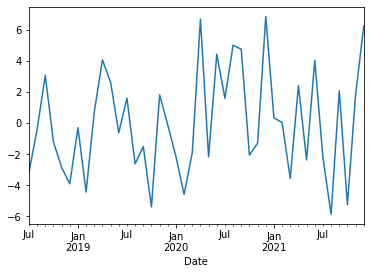

In [ ]:
err.plot()
plt.show()

**23.	Выведите на экран описательные статистики ошибок, воспользовавшись функцией describe(). Прокомментируйте результат.**

In [ ]:
err.describe()

count    4.20e+01
mean     8.12e-15
std      3.45e+00
min     -5.87e+00
25%     -2.33e+00
50%     -3.54e-01
75%      2.32e+00
max      6.83e+00
Name: Error, dtype: float64

**24.	Постройте для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из matplotlib.pyplot. Прокомментируйте результат.**

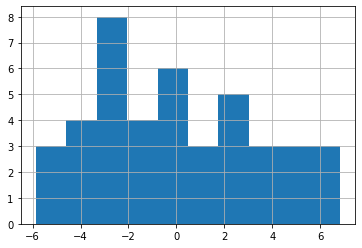

In [ ]:
err.hist()
plt.show()

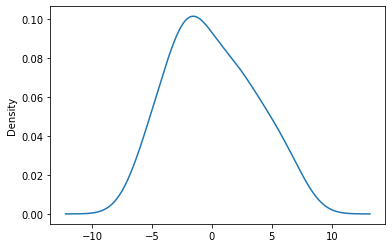

In [ ]:
err.plot(kind='kde')
plt.show()

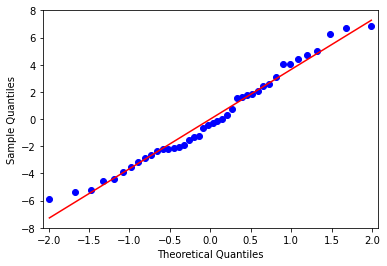

In [ ]:
qqplot(err,line='r')
plt.show()

**25.	Постройте для ошибок коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting. Прокомментируйте результат.**

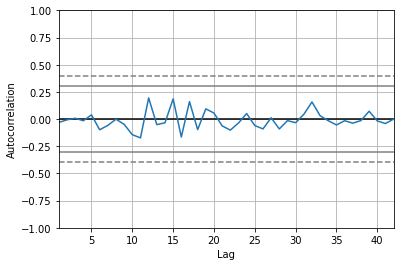

In [ ]:
autocorrelation_plot(err)
plt.show()

**26.	Рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma =scipy.stats.sem(y)
sigma

2.0543173173993114

**27.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
confidence=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0195409639828936

**28.	Возьмите в качестве факторов на прогнозном интервале с 49 по 60 наблюдения (x_new) значения факторов тестового набора (x_test).**

In [ ]:
x_new=x_test
x_new

array([[56.50772727, 62.36857143, 70.47095238, 68.49318182, 66.9935    ,
        75.04318182],
       [62.36857143, 70.47095238, 68.49318182, 66.9935    , 75.04318182,
        77.83263158],
       [70.47095238, 68.49318182, 66.9935    , 75.04318182, 77.83263158,
        77.77105263],
       [68.49318182, 66.9935    , 75.04318182, 77.83263158, 77.77105263,
        71.97636364],
       [66.9935    , 75.04318182, 77.83263158, 77.77105263, 71.97636364,
        72.92714286],
       [75.04318182, 77.83263158, 77.77105263, 71.97636364, 72.92714286,
        72.3685    ],
       [77.83263158, 77.77105263, 71.97636364, 72.92714286, 72.3685    ,
        74.73545455],
       [77.77105263, 71.97636364, 72.92714286, 72.3685    , 74.73545455,
        70.24047619],
       [71.97636364, 72.92714286, 72.3685    , 74.73545455, 70.24047619,
        60.23      ],
       [72.92714286, 72.3685    , 74.73545455, 70.24047619, 60.23      ,
        60.91380952],
       [72.3685    , 74.73545455, 70.24047619, 60.

**29.	Найдите прогнозные значения цены на материал 3 на год вперед (точечный прогноз), воспользовавшись функцией predict() модели линейной регрессии. Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new=model.predict(x_new)
y_new

array([77.49677833, 77.74109681, 75.53693293, 70.51954544, 74.74470523,
       70.71688474, 72.45185475, 66.09520532, 58.83851466, 60.7069729 ,
       53.27791435, 52.40411207])

**30.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

array([81.6455563 , 81.88987478, 79.68571091, 74.66832341, 78.89348321,
       74.86566271, 76.60063272, 70.2439833 , 62.98729263, 64.85575088,
       57.42669233, 56.55289004])

**31.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

array([73.34800035, 73.59231883, 71.38815496, 66.37076746, 70.59592726,
       66.56810676, 68.30307677, 61.94642735, 54.68973668, 56.55819493,
       49.12913638, 48.25533409])

**32.	Сгенерируйте номера наблюдений для выборки и прогнозного интервала. Поместите их в переменные 't' и 't_new' соответственно. Они вам понадобятся при построении диаграммы.**

In [ ]:
t=np.arange(1,43)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

In [ ]:
t_new=np.arange(43,55)
t_new

array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])

In [ ]:
t_new=t_new.reshape(-1,1)

**33.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.**

In [ ]:
i= list(np.arange(49,53))
i

[49, 50, 51, 52]

In [ ]:
j= list(series_2022.values)

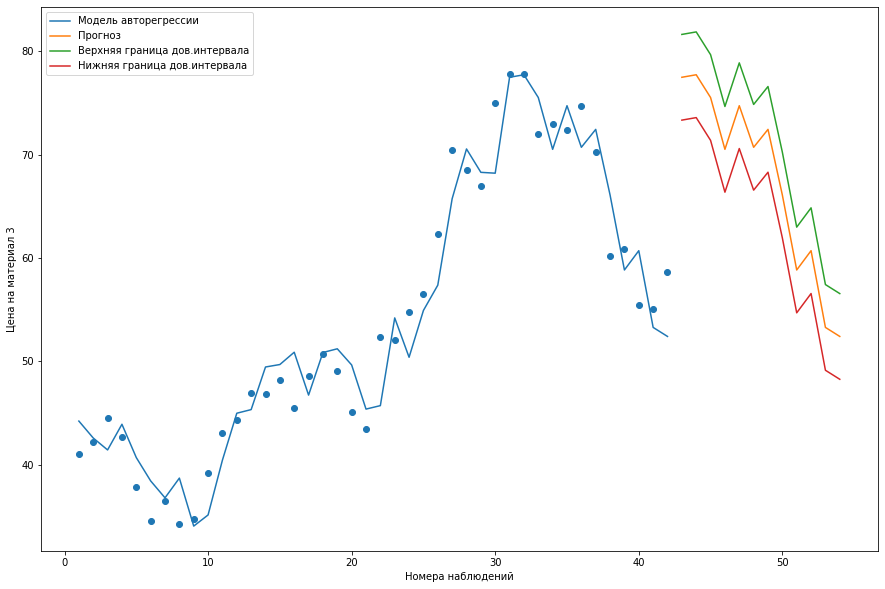

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(t,y)

plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel('Номера наблюдений')
plt.ylabel('Цена на материал 3')
plt.legend(['Модель авторегрессии','Прогноз','Верхняя граница дов.интервала','Нижняя граница дов.интервала'])

plt.show()

# **7.1. Построение модели авторегрессии с помощью функции AutoReg**

**34.	Вытащите значения переменной series, обратившись к параметру values. Результат запишите в переменную X.**

In [ ]:
X=series.values

**35.	Разделите выборку на обучающую и тестовую (12 последних наблюдений). Результат запишите в переменные train и test.**

In [ ]:
train, test = X[0:len(X)-12], X[len(X)-12:]

# **СТАТИЧЕСКАЯ МОДЕЛЬ АВТОРЕГРЕССИИ**

**36.	Постройте статическую модель авторегрессии. Воспользуйтесь функцией AutoReg(data, lags=lags,old_names=False) из модуля statsmodels.tsa.ar_model, чтобы автоматизировать процесс построения авторегрессии. Результат запишите в переменную model. Используйте тот же порядок авторегрессии, что и ранее.**

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [ ]:
model=AutoReg(train, lags=6,old_names=False)

**37.	Обучите созданную модель, воспользовавшись функцией fit(). Результат запишите в переменную model_fit.**

In [ ]:
model_fit=model.fit()

**38.	Выведите на экран коэффициенты модели, обратившись к параметру модели params.**

In [ ]:
model_fit.params

array([-1.13058381,  0.24478978,  0.67201834, -0.06657351, -0.33216294,
        0.30568777,  0.28957294])

**39.	 Сделайте прогноз по модели для тестовой выборки, воспользовавшись функцией predict(start=start, end=end, dynamic=False). Результат запишите в переменную predictions.**

In [ ]:
predictions=model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predictions

array([10.16431481, 10.1604081 , 10.17874681, 10.18877065, 10.1959967 ,
       10.20605869, 10.20956998, 10.21785539, 10.22754769, 10.23702378,
       10.24930723, 10.25927188])

**40.	Выведите на экран для каждого наблюдения из тестового набора его прогнозное (predictions) и фактическое значение (test), воспользовавшись циклом for и функцией print().**

In [ ]:
for i in range(len(predictions)):
  print('predicted=%f, expected=%f' %(predictions[i], test[i]))

predicted=10.164315, expected=10.150000
predicted=10.160408, expected=10.150000
predicted=10.178747, expected=10.180000
predicted=10.188771, expected=10.180000
predicted=10.195997, expected=10.160000
predicted=10.206059, expected=10.170000
predicted=10.209570, expected=10.140000
predicted=10.217855, expected=10.160000
predicted=10.227548, expected=10.120000
predicted=10.237024, expected=10.140000
predicted=10.249307, expected=10.120000
predicted=10.259272, expected=10.150000


**41.	Выведите на экран значение RMSE на тестовом наборе, воспользовавшись функцией sqrt() из модуля math и функцией mean_squared_error(test, predictions) из модуля sklearn.metrics.**

In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.07118975750556977

In [ ]:
R2=r2_score(test,predictions)
R2

-12.927277607119402

**42.	Нанесите на одну диаграмму фактические и прогнозные значения для тестового набора, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Прогноз изобразите красным цветом, указав атрибут color='red' в функции plot().**

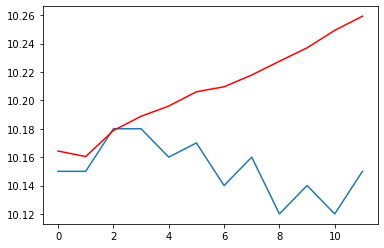

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# **ДИНАМИЧЕСКАЯ МОДЕЛЬ АВТОРЕГРЕССИИ**

**43.	 Постройте динамическую модель авторегрессии. Проведите пересчет значений по модели при условии поступления на каждом шаге нового наблюдения из тестового набора. Расчет ведите на основе найденных в ходе обучения коэффициентов модели и последних наблюдений в количестве, равном лагу. Выведите на экран для каждого наблюдения из тестового набора его прогнозное и фактическое значение. Это потребует выполнения следующего кода:**

In [ ]:
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
window = 6
model = AutoReg(train, lags=6,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=10.164315, expected=10.150000
predicted=10.156904, expected=10.150000
predicted=10.166579, expected=10.180000
predicted=10.183036, expected=10.180000
predicted=10.200140, expected=10.160000
predicted=10.190351, expected=10.170000
predicted=10.169394, expected=10.140000
predicted=10.179272, expected=10.160000
predicted=10.178672, expected=10.120000
predicted=10.174883, expected=10.140000
predicted=10.158797, expected=10.120000
predicted=10.157086, expected=10.150000


**44.	Рассчитайте значение RMSE на тестовом наборе, воспользовавшись функцией sqrt() из модуля math и функцией mean_squared_error(test, predictions) из модуля sklearn.metrics.**

In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.0287478565959798

**45.	Нанесите на одну диаграмму фактические и прогнозные значения для тестового набора, воспользовавшись функциями plot() и show() из модуля matplotlib.pyplot. Прогноз изобразите красным цветом, указав атрибут color='red' в функции plot().**

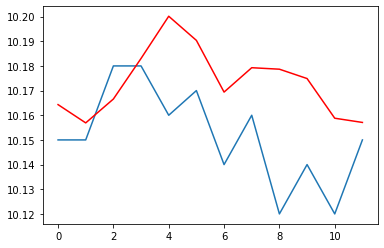

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# **ОПРЕДЕЛЯЕМ ОПТИМАЛЬНЫЙ ПО КРИТЕРИЮ BIC ПОРЯДОК АВТОРЕГРЕССИИ**

**46.	 Воспользуйтесь функцией ar_select_order(data, maxlag=max_tau) из модуля statsmodels.tsa.ar_model, чтобы определить оптимальный по критерию BIC порядок авторегрессии. Результат запишите в переменную modelp.**

In [ ]:
modelp=ar_select_order(train, maxlag=max_tau)

**47.	Выведите на экран порядок авторегрессии, обратившись к параметру ar_lags.**

In [ ]:
lags=modelp.ar_lags
lags

[1, 2]

**48. Постройте статическую и динамическую модель авторегрессии с оптимальным лагом. Прокомментируйте полученный результат.**

In [ ]:
model=AutoReg(train, lags=lags,old_names=False)

In [ ]:
model_fit=model.fit()

In [ ]:
model_fit.params

array([-0.15743569,  0.41955524,  0.59655133])

In [ ]:
predictions=model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [ ]:
for i in range(len(predictions)):
  print('predicted=%f, expected=%f' %(predictions[i], test[i]))

predicted=10.162012, expected=10.150000
predicted=10.161086, expected=10.150000
predicted=10.167863, expected=10.180000
predicted=10.170154, expected=10.180000
predicted=10.175158, expected=10.160000
predicted=10.178624, expected=10.170000
predicted=10.183063, expected=10.140000
predicted=10.186993, expected=10.160000
predicted=10.191291, expected=10.120000
predicted=10.195438, expected=10.140000
predicted=10.199742, expected=10.120000
predicted=10.204022, expected=10.150000


In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.04166487551247743

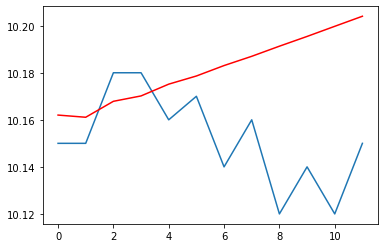

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
window = 2
model = AutoReg(train, lags=lags,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=10.162012, expected=10.150000
predicted=10.156046, expected=10.150000
predicted=10.156046, expected=10.180000
predicted=10.168633, expected=10.180000
predicted=10.186529, expected=10.160000
predicted=10.178138, expected=10.170000
predicted=10.170403, expected=10.140000
predicted=10.163782, expected=10.160000
predicted=10.154276, expected=10.120000
predicted=10.149425, expected=10.140000
predicted=10.133954, expected=10.120000
predicted=10.137494, expected=10.150000


In [ ]:
RMSE =sqrt(mean_squared_error(test,predictions))
RMSE

0.018724522424567777

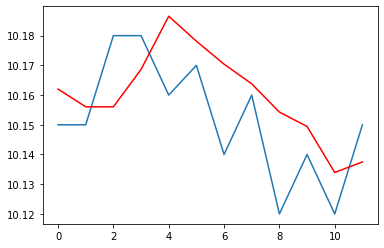

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()